# Training SCINet

This notebook shows how SCINet can be trained on a particular dataset. It therefore serves as a very good introduction for working with SCINet. It focusses on the preprocessing procedure as well as the training phase. To that end, a very simple dataset called 'toy_dataset_sine' is used. Its features are:
- Feature 1: $\sin(\frac{2\pi}{1000}*\mathrm{time})+\mathcal{N}(0,0.1)$
- Feature 2: $\frac{1}{2}\cdot \sin(\frac{2\pi}{10}*\mathrm{time})+\mathcal{N}(0,0.1)$
- Feature 3: Feature 1 * Feature 2

Here, $\mathcal{N}$ denotes random Gaussian noise.

Before we can truly make a start however, we will import some libraries. Also, we will add the base of the SCINET folder to our path:

In [1]:
import os
import sys
import numpy as np
import pandas as pd

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR)


### Importing and visualising the raw data

We will begin by importing the raw data from the datasets folder:

In [2]:

raw_data = np.loadtxt(BASE_DIR + '/datasets/toy_dataset_sine.csv')

print('Total number of features: {}'.format(raw_data.shape[1]))
print('Total number of timesteps: {}'.format(raw_data.shape[0]))
print('Size of timestep (dt): {}'.format(raw_data[1,0]-raw_data[0,0]))

Total number of features: 4
Total number of timesteps: 50000
Size of timestep (dt): 1.0


Here, the reason the number of features equals 4 is because the zeroth column holds the timestamps of the different datapoints. This is rather trivial in case of this toy dataset but is important if the raw data is 'dirty'. That is, the dataset contains missing values. Before we start manipulating this data, it is important to first visualize the data:

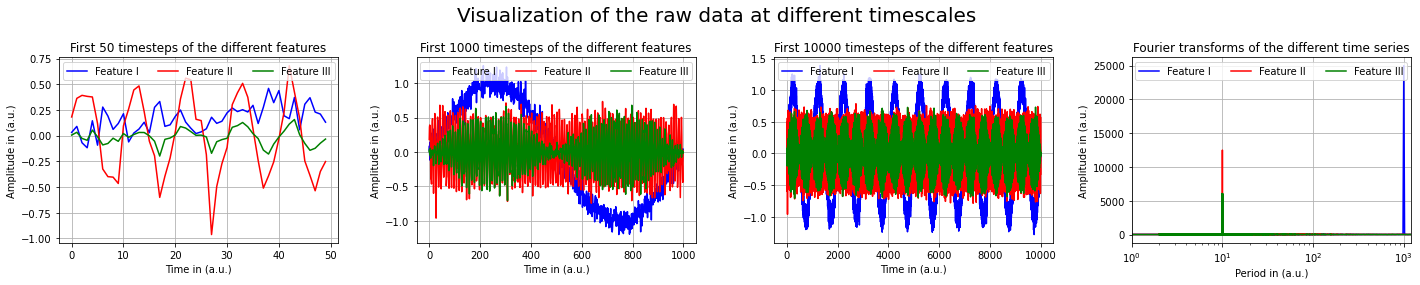

In [3]:
from utils.plotting import plot_raw_data

# Figure settings
ax1_x_len = 50
ax2_x_len = 1000
ax3_x_len = 10000

plot_raw_data(raw_data, [ax1_x_len, ax2_x_len, ax3_x_len])



As the data is self-generated, the raw data is in line as it is described in the datasets README.md. That is, feature I oscillates with a period of 1000, therefore only showing clear oscillating behavior in plots 2 and 3 where the timescales are largest. Feature II however oscillates one hundred times as fast and as such its oscillations are also clearly visible at the smalles timescale. Feature 3, shows clear nodes when Feature I is equal to zero in figure 2. These different periods also clearly show up in the fourier transforms of the different time series.

### Data preprocessing

Now that we have loaded in the data and found out what we are dealing with by means of visualization, we need to preprocess the data such that it is in a format that SCINet can use to train on. For long time series such as these ones, this is composed of two steps. The first of these is to divide the long time series into smaller time series. These smaller time series will be the samples in our dataset. These smaller time series are then subdivided into two parts, the data and the labels. The data, also denoted as X, will be fed into SCINet, the labels, also Y, are then used to compare predictions with and will therefore serve as ground truths. These (X,y)-pairs are then divided into a training, validation and test set. The procedure is graphically depicted below:
![title](images/preprocessing.png)

For the second part of the preprocessing we can choose to standardize the data. Once again, with data as neat as this toy set this is not strictly neccessary, however it is important if features span different orders of magnitude as to give them all equal weight. There is two ways in which we can do this. Either we can choose to normalize every sample individually, or we normalize using the mean and standard deviation calculated over all samples and timesteps of that sample. Here, it is important to use only the X part of the data and not include the labels, as to prevent data leakage from the labels to the data. Although this subtelty is ignored for now it turns out to be very relevant and it is addressed further in the 'reprod(uction)' example. In addition to standard normalization we can also apply a function before normalization (as long as it is bijective). This is useful if the features themselves span multiple orders of magnitude. To perform all steps, one can call the 'preprocess_data.py' file stored in the base directory. In our case, we will choose to normalize over both the X timesteps and the samples without applying any pre-normalization function. 

In [4]:
from base.preprocess_data import preprocess

column_names = ['timestamp',' feature I',' feature II',' feature III']
X_len = 40
Y_len = 20

raw_data_pd = pd.DataFrame(raw_data, columns= column_names)
standardization_settings = {
                    'per_sample': False,
                    'leaky': False,
                    'mode': 'lin', #only if per sample is false, choose from log, sqrt or lin
                    'sqrt_val': 2, #of course only if mode is sqrt
                    'total mean': [],
                    'total std': []}

preprocessed_data = preprocess(
                data = {'toy_data': raw_data_pd} ,
                symbols = ['toy_data'] ,
                data_format = column_names, 
                fraction = 1,
                train_frac = 0.7,
                val_frac = 0.15,
                test_frac = 0.15,
                X_LEN = X_len,
                Y_LEN = Y_len,
                OVERLAPPING = False,
                STANDARDIZE = True,
                standardization_settings = standardization_settings,
                )



c:\Users\PimVeefkind\Documents\ADL-Scinet\SCINet\base\preprocess_data.py:50: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data[symbol] = data[symbol].drop(data[symbol].columns[0], 1)


Starting data preprocessing...
    feature I   feature II   feature III
0    0.031595     0.181848      0.005745
1    0.090240     0.363144      0.032764
2   -0.068956     0.392331     -0.027050
3   -0.117901     0.382471     -0.045079
4    0.144855     0.376493      0.054510 (50000, 3)
Making train/validation/test splits...
Making samples...


100%|██████████| 583/583 [00:00<00:00, 5971.64it/s]
c:\Users\PimVeefkind\Documents\ADL-Scinet\SCINet\base\preprocess_data.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(samples)


Making samples...


100%|██████████| 124/124 [00:00<00:00, 4807.98it/s]


Making samples...


100%|██████████| 124/124 [00:00<00:00, 11273.06it/s]

Making X-y splits...


To demonstrate the new data format one of the samples is plotted:

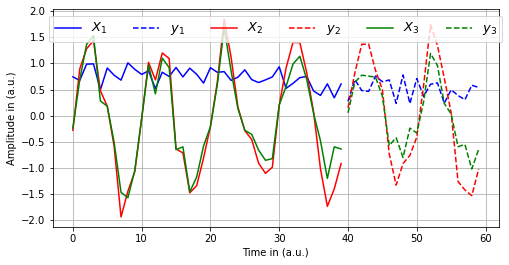

In [5]:
from utils.plotting import plot_preprocessed_data

sample_number = np.random.randint(preprocessed_data['X_train'].shape[0])
X_sample = preprocessed_data['X_train'][sample_number,:,:]
Y_sample = preprocessed_data['y_train'][sample_number,:,:]

plot_preprocessed_data(X_sample, Y_sample)

### Training

Finally then we are in a position to train SCINet on the data. For this we will use the 'train_scinet' function from the 'train_scinet.py' file in the base folder. After hyperparameter settings are chosen, training proceeds automatically. For this demonstration we will use two stacked SCInets (num_levels = 2) to predict all three features in the data. The relevance/influence of other hyperparameters will be further explored in the hyperparameter example. Furthermore, an explanation of what they all do can be found in the description of the train_scinet function in base/train_scinet.py

In [6]:
from base.train_scinet import train_scinet

n_epochs = 50
n_features = 3
n_features_list = np.arange(n_features)

results = train_scinet(
            X_train= preprocessed_data['X_train'],
            y_train= preprocessed_data['y_train'],
            X_val= preprocessed_data['X_val'],
            y_val= preprocessed_data['y_val'],
            X_test= preprocessed_data['X_test'],
            y_test= preprocessed_data['y_test'],
            epochs = n_epochs,
            batch_size = 64,
            X_LEN = X_len,
            Y_LEN = [Y_len,Y_len],
            output_dim = [n_features,n_features],
            selected_columns = [n_features_list,n_features_list],
            hid_size= 32,
            num_levels= 2,
            kernel = 5,
            dropout = 0.3,
            loss_weights= [0.3,0.7],
            learning_rate = 0.005,
            probabilistic = False,
            )

model = results[0]
history = results[1]

===========================[SCINET]=====================================
Initializing training with data:
X_train: (583, 40, 3), y_train: (583, 20, 3)
X_val: (124, 40, 3), y_val: (124, 20, 3)
X_test: (124, 40, 3), y_test: (124, 20, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 3)]      0           []                               
                                                                                                  
 Block_0 (SCINet)               (None, 20, 3)        68084       ['input_1[0][0]']                
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 40, 3)       0           ['input_1[0][0]']                
 a)                                                      

To get a first indication on how training proceeded, let us plot the loss functions throughout training:

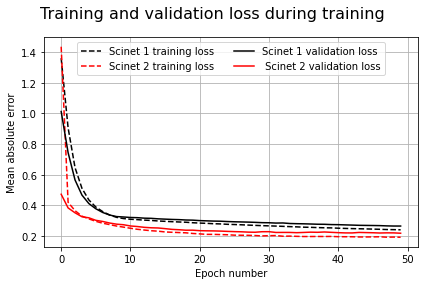

In [7]:
from utils.plotting import plot_loss_curves

losses = list(history.history.values())

plot_loss_curves(n_epochs, losses[1:3]+losses[4:])


We observe that the training and validation loss go down nicely. To get a more concrete picture of the accuracy of our predictions, let us plot some example predictions:

C:\Users\PimVeefkind\AppData\Local\Temp\ipykernel_8128\489704189.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


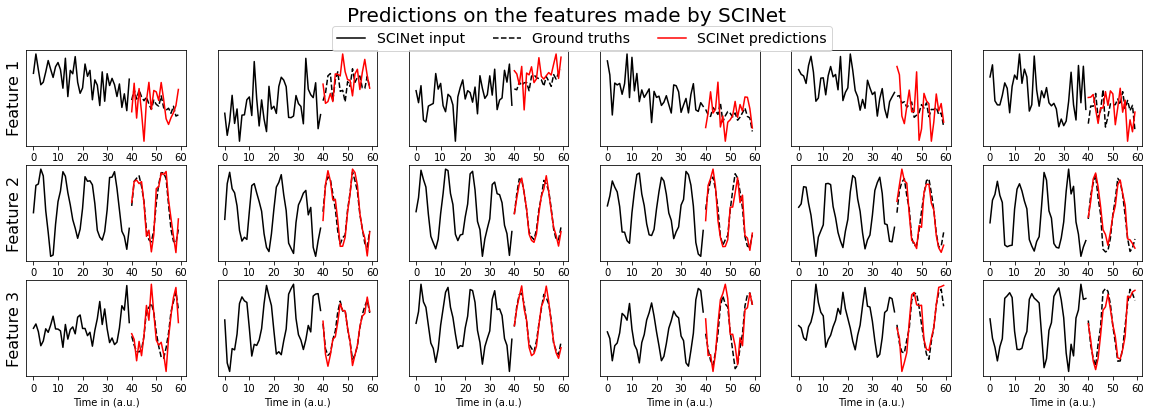

In [15]:
from utils.plotting import plot_prediction_examples

n_samples = 6
test_samples = np.random.randint(low = 0, high = preprocessed_data['X_test'].shape[0], size = n_samples)

x_samples = preprocessed_data['X_train'][test_samples,:,:]
y_true_samples = preprocessed_data['y_train'][test_samples,:,:]
y_pred_samples = model.predict(preprocessed_data['X_train'][test_samples,:,:])[-1]

plot_prediction_examples(n_samples,x_samples , y_true_samples, y_pred_samples, )



We observe that SCINet is indeed able to make quite accurate predictions on this dataset! The only thing that rests us to do then is to save the model that we have created by training:

In [9]:
model.save('saved_models/model_toy_dataset_sines')

INFO:tensorflow:Assets written to: saved_models/model_toy_dataset_sines\assets


INFO:tensorflow:Assets written to: saved_models/model_toy_dataset_sines\assets
